# Ensemble resampling

Like other offline data assimilation products, the Last Millennium Reanaalysis was generated from an Ensemble Kalman Filter, which samples from a time-invariant prior distribution of climate states before judging its consistency with the observations. By definition, offline DA treats each reconstruction interval (here, years), as independent; in fact, the algorithm works identically if years are swapped, exchanged with replacement, etc.  Thus, any trajectory encompassed by these distributions is technically allowed, as long as these paths preserve the distribution, particularly its low-order moments (mean, variance). However, within those loose constraints, not all resampling choices are equivalent, as some may result in a temporal structure that no longer respects what is independently known about climate variability (e.g. long-range memory).  The challenge is thus to come up with resampling schemes that satisfy both constraints:
- respect the posterior distribution obtained via the Kalman filter
- respect independent constraints on temporal structure. 

This notebooks illustrates these challenges by apply a naïve resampling strategy to the LMR ensemble, before briging other constraints to bear. It concludes with Fig 5 of the paper.

In [1]:
%load_ext autoreload
%autoreload 2
import pens
import matplotlib.pyplot as plt
plt.style.use('default')
pens.set_style()

We first load the LMR v2.1 global mean surface temperature (GMST) for illustration:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:title={'center':'LMR v2.1'}, xlabel='time', ylabel='GMST [°C]'>)

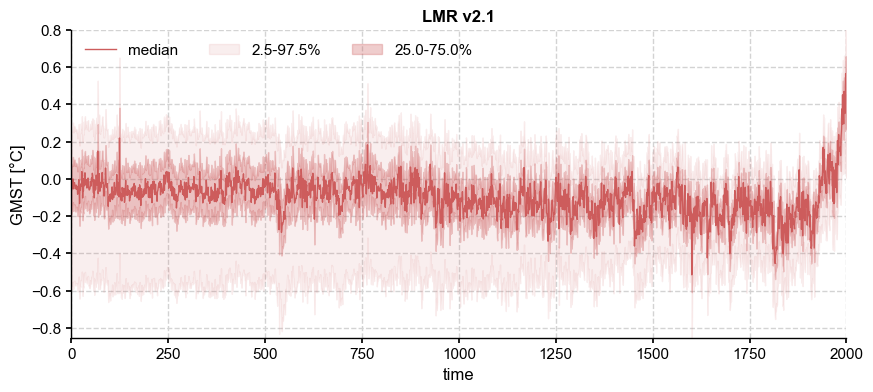

In [2]:
path = '../data/gmt_MCruns_ensemble_full_LMRv2.1.nc'
ens_LMR = pens.EnsembleTS().load_nc(path, var='gmt')
ens_LMR.label = 'LMR v2.1'
ens_LMR.value_name = 'GMST'
ens_LMR.value_unit = '\N{DEGREE SIGN}C'
ens_LMR.plot_qs()

As expected from the loss of degrees of freedom due to proxy attribution, the ensemble spread increases back in time, while the ensemble median becomes increasingly flat. In other words, there is a generally inverse relationship between the temporal variance of the distribution's central moment (the median or mean) and the variance across the ensemble at a fixed time. The individual trajectories that make up the ensemble may be visualized thus:

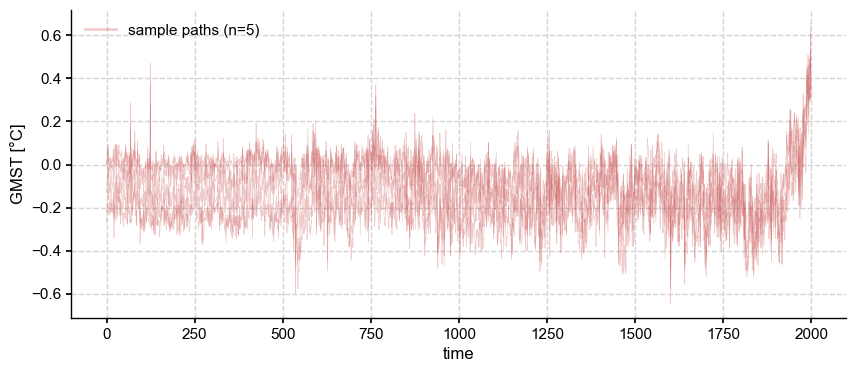

In [3]:
ens_LMR.plot_traces(num_traces=5, alpha = 0.3, color = 'indianred')

Notice that the same inverse relationship holds true for each of these ensemble members: their temporal fluctuations diminish back in time, while their get spread further apart. However, it is important to realize that these trajectories are simply labels: trajectory $i$ is simply the $i$th member of this ranked ensemble, but one could just as legitimately reshuffle labels at each time step, like so:

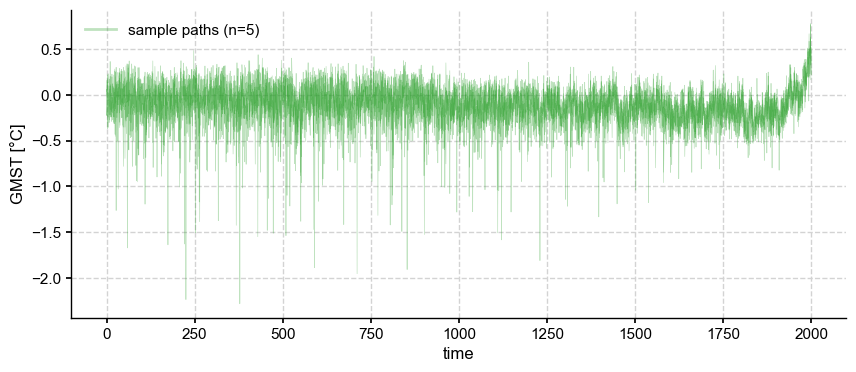

In [4]:
ens_unif = ens_LMR.random_paths(model='unif',p=5)
ens_unif.plot_traces(color='tab:green',alpha=0.3, num_traces=5)

The resampling results in a much greater temporal variance, with many "cold" years from the posterior (usually, those corresponding to the aftermath of strong volcanic eruptions in the CCSM4 prior) being sampled with replacement. However, it is easy to check that the ensemble variance is unchanged:

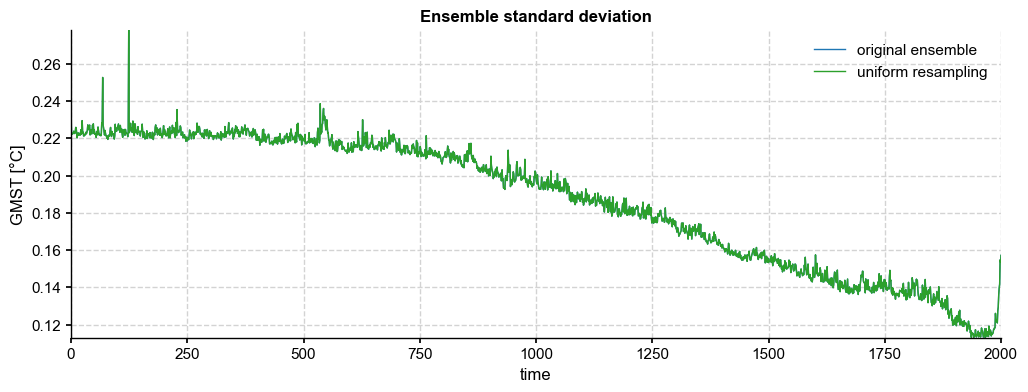

In [5]:
fig, ax = ens_LMR.get_std().plot(label='original ensemble')
ens_unif.get_std().plot(color='tab:green',ax=ax, label='uniform resampling', title='Ensemble standard deviation')
ax.legend()

How do we satisfy these constraints while respecting the laws of physics as they apply to the temporal structure of climate variability? To do this, we need to bring in independent information. 

## Independent constraints on temporal structure

This information may come in several forms, e.g. studies of instrumental climate variability, which suggest that the spectrum of GMST $S(f)$ behaves as a power law of the form  $S(f) \propto f^{-\beta}$, where $\beta \approx 1$ over the instrumental era (see e.g. Huybers & Curry [2005] or Zhu et al. [2019]). However, the last 150 years are too short to usefully distringhuish between several models of temporal behavior, such as long- or short-range memory (e.g. Barboza et al 2014). 

Another constraint comes from the temporal behavior of the online LMR algorithm of Perkins & Hakim [2021]. Unlike offline DA, online DA carries information from timestep to timestep via an explicit model (here, a linear inverse model, or LIM). This results in much improved reconstruction of quantities, like the ocean heat content, that are known to exhibit long-term memory but are only indirectly constrained by most climate proxy observations. To a lesser extent, Perkins & Hakim [2021] also showed improved reconstructions of GMST, with a narrower ensemble spread and more homoskedastic behavior of the ensemble mean (or median). 
Let us load and visualize this reconstruction:

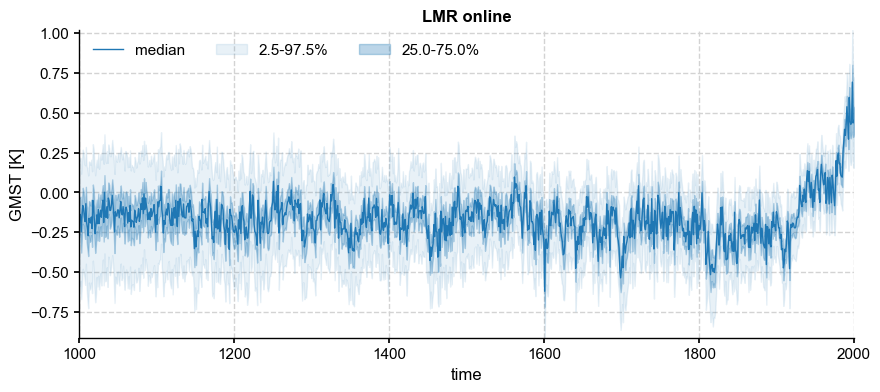

In [6]:
ens_o = pens.EnsembleTS().load_nc('../data/gmt_MCruns_ensemble_full_LMRonline.nc', var='glob_mean', time_name='year')
ens_o.label = 'LMR online'
fig, ax = ens_o.plot_qs(ylabel='GMST [K]', color = 'tab:blue')

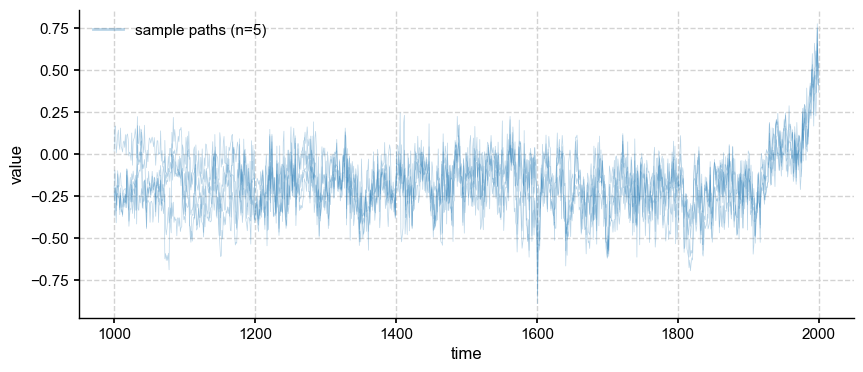

In [7]:
ens_o.plot_traces(num_traces=5, alpha=0.3, color = 'tab:blue')

The individual traces also retain more temporal variance than their offline counterparts (see above). 

To devise a sensible resampling scheme, we analyze the spectral behavior of the online LMR to determine which timeseries model would be most appropriate. Because the ensemble mean may be viewed as a deterministic response to external forcing (e.g. explosive volcanism), we analyze the spectral behaior of residuals from the mean:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:title={'center':'LMR online (centered)'}, xlabel='time', ylabel='value'>)

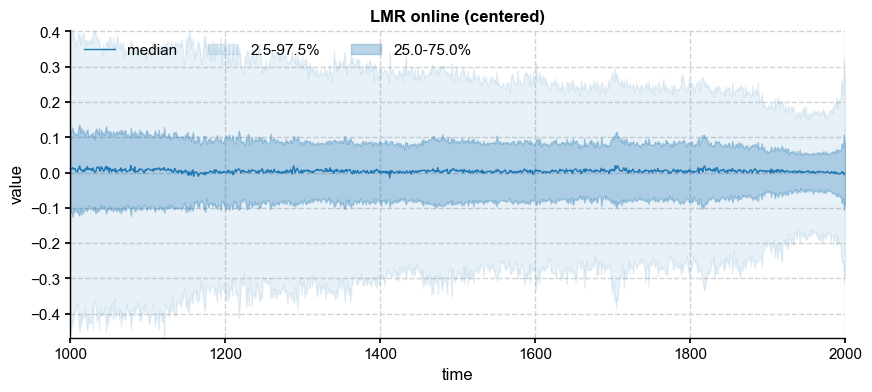

In [9]:
ens_o2000 = ens_o.subsample(nsamples=ens_LMR.nEns) # downsample to the same ensemble size as LMRv2.1
ens_mean = ens_o2000.get_mean()
ens_d = ens_o2000 - ens_mean
ens_d.label = ens_o2000.label + " (centered)"
ens_d.plot_qs(color='C0')

In [10]:
PSD_o = ens_d.to_pyleo().spectral(method='mtm',settings={'standardize':False}) # this generate a MultiplePSD object

Performing spectral analysis on individual series: 100%|██████████| 2000/2000 [00:57<00:00, 34.97it/s]


In [11]:
PSD_oaa = PSD_o.anti_alias()

Applying the anti-alias filter: 100%|██████████| 2000/2000 [00:26<00:00, 76.69it/s]


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period', ylabel='PSD'>)

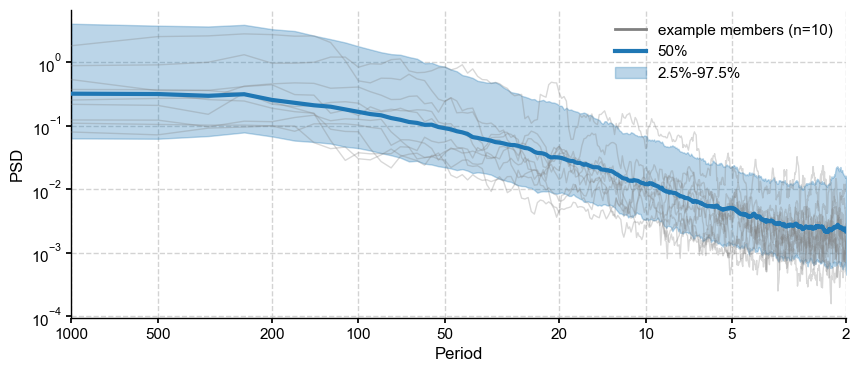

In [12]:
PSD_oaa.plot_envelope(curve_clr='tab:blue',shade_clr='tab:blue')

The median spectrum is not so different from an AR(1) (the aliasing at periods shorter than ~3y can be ignored). Let's extract it, add random phase, and invert it back to the time domain. 

Let's do this as in [this example](https://dsp.stackexchange.com/a/7703)

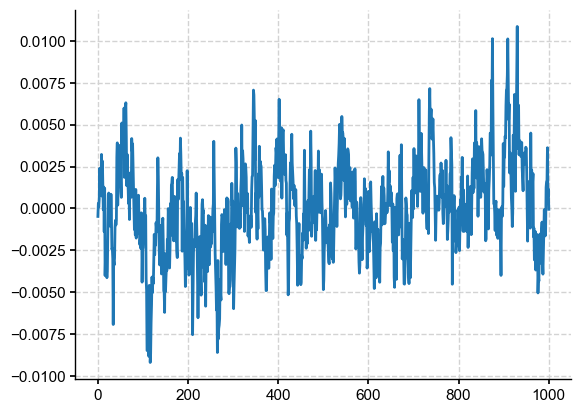

In [13]:
import numpy as np
PSD_median = PSD_oaa.quantiles().psd_list[1].amplitude

nfrms = 2*ens_o.nt//2
len_ser = int((nfrms-1)/2)
interv1 = np.arange(1, len_ser+1)
interv2 = np.arange(len_ser+1, nfrms)

median_ts = np.zeros((nfrms))
ph_rnd = 2*np.pi*np.random.rand(nfrms) # random phases

magnitude = np.zeros((nfrms))
magnitude[interv1] = np.sqrt(PSD_median[interv1])
magnitude[interv2] = np.flipud(magnitude[interv1])
# Create the random phases for all the time series
FFT = magnitude*np.exp(1j*ph_rnd)
#ph_interv2 = np.conj(np.flipud(ph_interv1))

# Inverse transform
median_ts = np.real(np.fft.ifft(FFT))
plt.plot(median_ts)

 Let's fit an autoregressive model to this series:

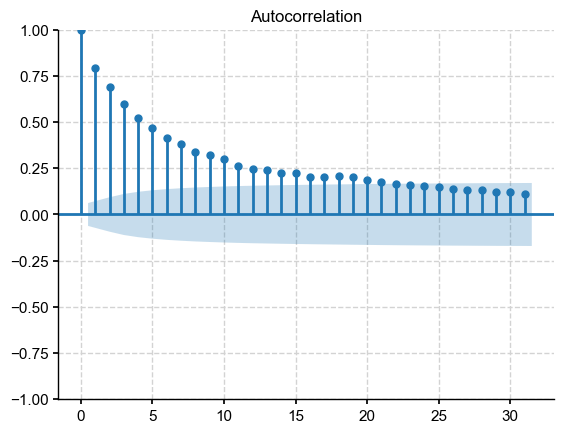

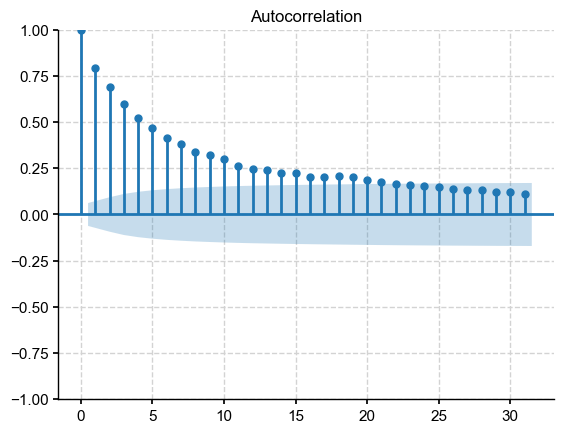

In [14]:
import statsmodels as sm
y = median_ts
sm.graphics.tsaplots.plot_acf(y)

In [15]:
from statsmodels.tsa.ar_model import AutoReg
max_lag = 15 
ar_mod = AutoReg(y, max_lag)
ar_res = ar_mod.fit(cov_type='HAC', cov_kwds={'maxlags': max_lag})  # Heteroskedasticity-autocorrelation robust covariance estimation.
print(ar_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1001
Model:                    AutoReg(15)   Log Likelihood                4894.074
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Sun, 18 Dec 2022   AIC                          -9754.148
Time:                        14:21:17   BIC                          -9670.956
Sample:                            15   HQIC                         -9722.508
                                 1001                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.611e-06   5.37e-05     -0.030      0.976      -0.000       0.000
y.L1           0.6621      0.031     21.282      0.000       0.601       0.723
y.L2           0.1341      0.039      3.442      0.0

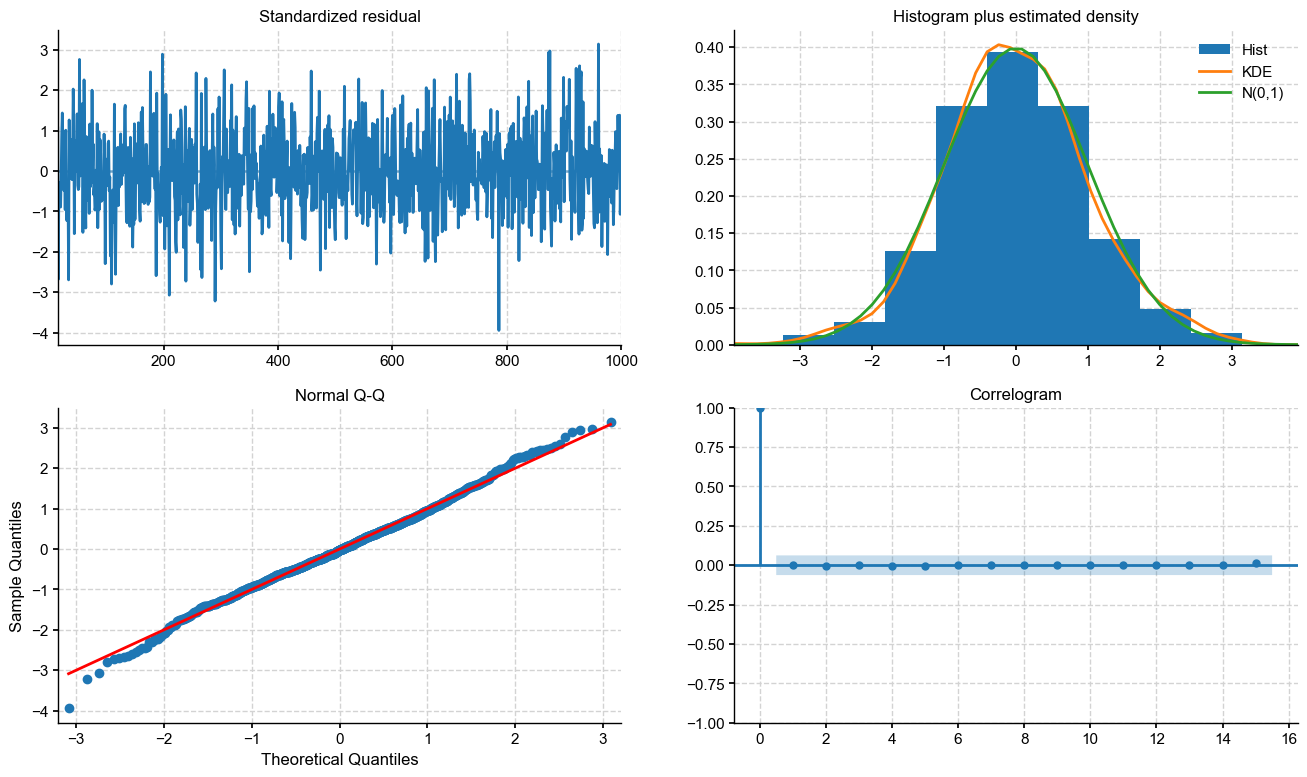

In [16]:
fig = plt.figure(figsize=(16, 9))
fig = ar_res.plot_diagnostics(fig=fig, lags=max_lag)

An excellent fit, except for some of the more extreme values.  Let's see what AR order is being determined automatically. From the CIs on coefficients, it looks like 2-4 would be a good choice:

In [17]:
mod_sel = sm.tsa.ar_model.ar_select_order(y, maxlag=max_lag)
ar_order = len(mod_sel.ar_lags)
print("retained AR order: "+str(ar_order))

retained AR order: 2


AR(2) it is. All we need to do now is pass those parameters to the `._random_paths()` function in `pens` to simulate sensible trajectories. Before we do so, let us obtain the distribution of AR parameters from the ensemble:

Text(0.5, 0.98, 'AR(2) fit to LMRonline median residual spectrum')

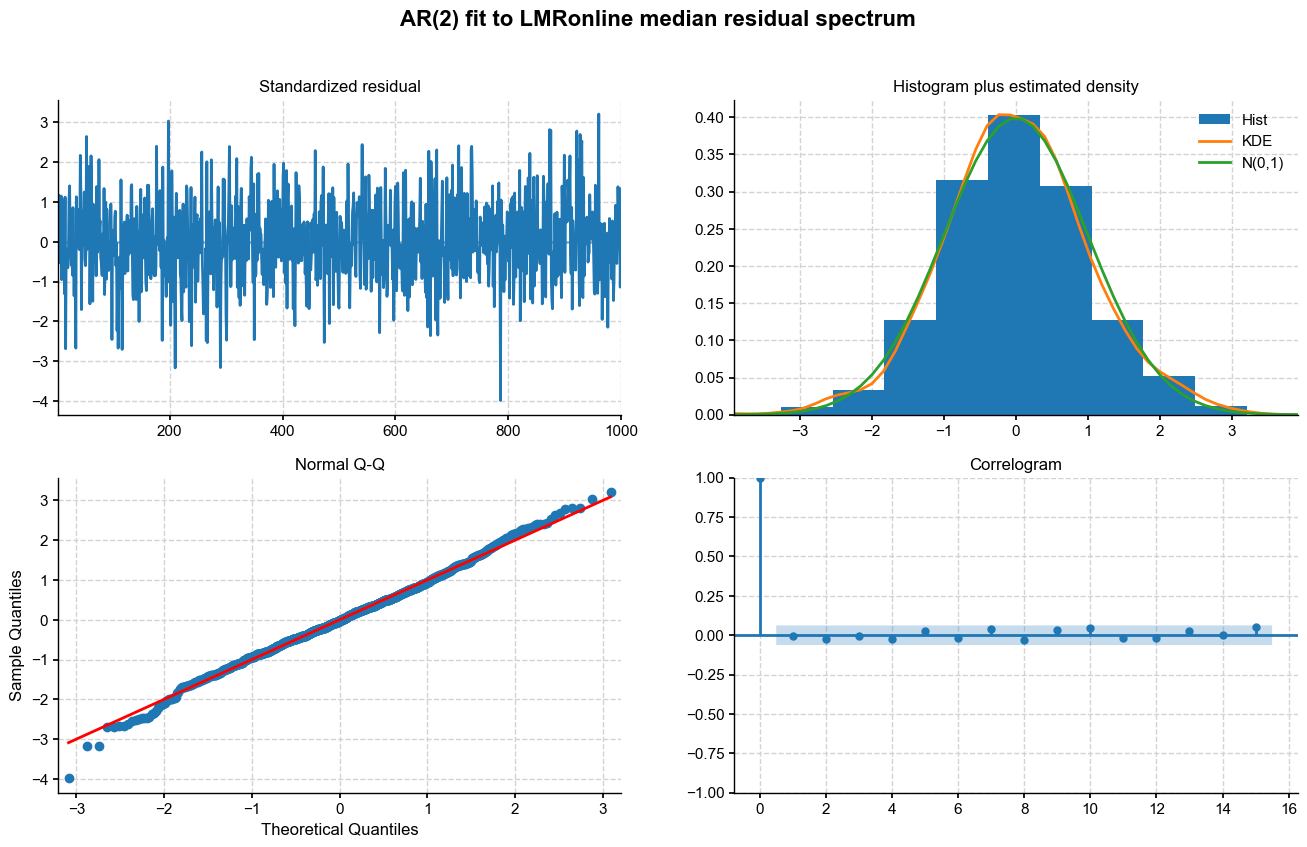

In [20]:
ar_mod = AutoReg(y, ar_order)
ar_res2 = ar_mod.fit(cov_kwds={'maxlags': ar_order})  # Heteroskedasticity-autocorrelation robust covariance estimation.
fig = plt.figure(figsize=(16, 9))
fig = ar_res2.plot_diagnostics(fig=fig, lags=max_lag)
fig.suptitle(f'AR({ar_order:d}) fit to LMRonline median residual spectrum',fontweight='bold',fontsize=16)

In [21]:
fig.savefig('../figures/LMRonline_AR2fit.pdf',dpi=300)

In [34]:
phi = np.empty((ens_d.nEns,ar_order+1))

for i in range(ens_d.nEns):
    ts_mod = AutoReg(ens_d.value[:,i], ar_order) # set up the model
    ts_res = ts_mod.fit(cov_type='HAC', cov_kwds={'maxlags': ar_order})  # Heteroskedasticity-autocorrelation robust covariance estimation.
    phi[i,:] = ts_res.params # export estimated parameters

Now let us plot the estimated parameters:

Text(0.5, 0.98, 'AR(2) fit to detrended LMR online GMST')

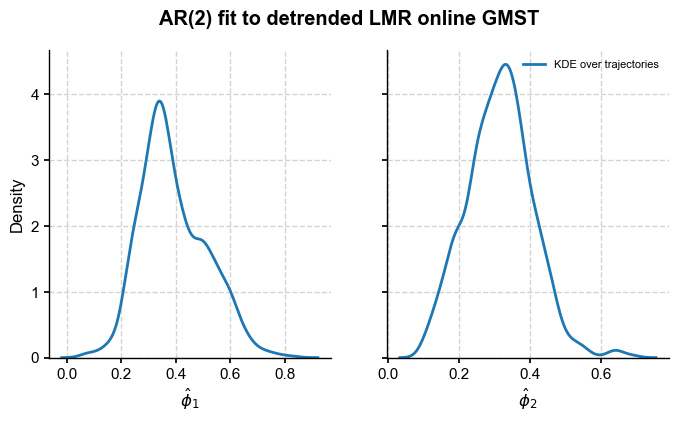

In [36]:
import seaborn as sns
fig, axs = plt.subplots(1,2,figsize=(8,4), sharey=True) 
axs = axs.flatten()
ymax = 25
for i in range(2):
    sns.kdeplot(phi[:,i+1],ax=axs[i],label='KDE over trajectories')
    axs[i].set_xlabel(r'$\hat{\phi}_'+str(i+1)+'$')
    
axs[1].legend(loc='upper right',fontsize=8)
fig.suptitle(f'AR({ar_order:d}) fit to detrended LMR online GMST',fontweight='bold')

This confirms that only the first 2 AR coefficients are appreciably different from 0 in most ensemble members, so an AR(2) fit is warranted. Let us compute the mean coefficients:

In [23]:
phi_o = ar_res2.params
print(phi_o)

[1.21050771e-08 6.61190915e-01 1.66350417e-01]


## Resampling the offline LMR

We now return to our original offline DA ensemble and try 3 timeseries models:
- an autoregressive model (AR(2))
- fractional Gaussian noise (fGn)
- power-law behavior

The target spectrum is the median of the distribution of detrended, standardized LMRonline spectra:

0.9302817663242721


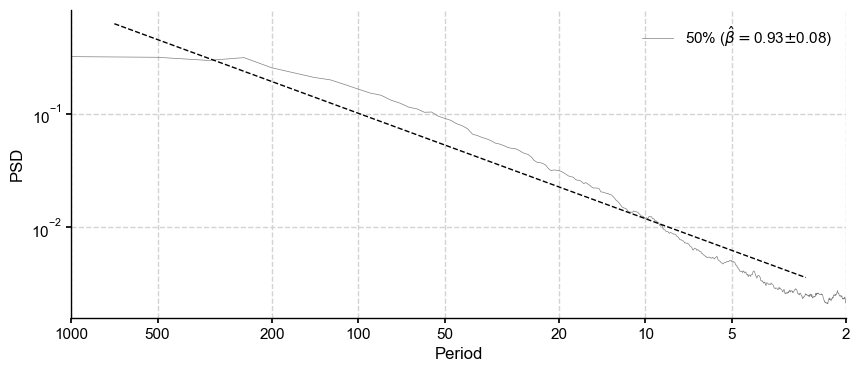

In [50]:
PSD_oaa_beta  = PSD_oaa.quantiles(qs=[0.5]).beta_est()
PSD_oaa_beta.plot()
beta_o = PSD_oaa_beta.beta_est_res['beta'][0]
print(beta_o)

### AR resampling

We start with an autoregressive model Because such models are stationary by construction, they cannot generate increasing variance back in time. We solve this problem (internally) by scaling the simulated AR series to unit variance, then rescaling it by the ensemble standard deviation. The result is here:

100%|██████████| 2000/2000 [00:00<00:00, 3955.43it/s]


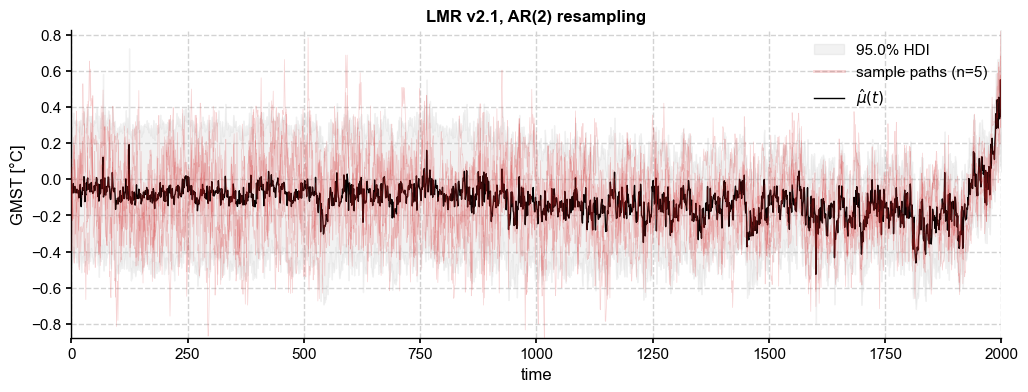

In [33]:
paths_ar = ens_LMR.random_paths(model='ar',param=phi_o,p=2000)
fig, ax = ens_LMR.plot_hdi(color='silver', median=False, prob=0.95)
paths_ar.plot_traces(ax=ax,alpha=0.2,color='tab:red',num_traces=5)
ens_LMR.get_mean().plot(ax=ax, color='k', ylabel=None, label=r'$\hat{\mu}(t)$', title= ens_LMR.label + ', AR(2) resampling')
ax.legend()

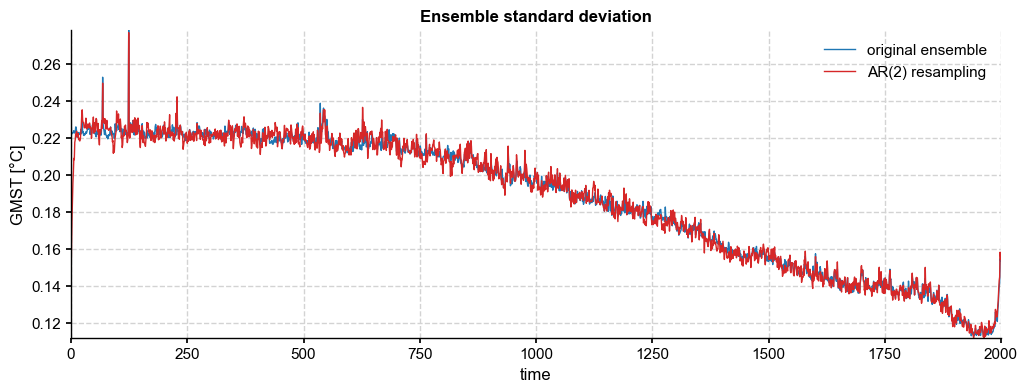

In [34]:
fig, ax = ens_LMR.get_std().plot(label='original ensemble')
paths_ar.get_std().plot(color='tab:red',ax=ax, label='AR(2) resampling', title='Ensemble standard deviation')
ax.legend()

In [35]:
ar_ts = paths_ar.to_pyleo()  
PSD_ar = ar_ts.spectral(method='mtm',settings={'standardize':False}) 

Performing spectral analysis on individual series: 100%|██████████| 2000/2000 [03:05<00:00, 10.77it/s]


In [36]:
PSD_ar_aa = PSD_ar.anti_alias()

Applying the anti-alias filter: 100%|██████████| 2000/2000 [00:39<00:00, 50.26it/s]


With 5000 ensemble members, we see that the AR(2) resampled ensemble achieves a sample standard deviation very close to the original, as must be the case by construction.

### Power law scaling
The last option is power-law scaling, enabled by the [stochastic package](https://stochastic.readthedocs.io/). Note that under certain conditions ($\beta  = 2H-1,  H<1$), results are equivalent  with fGn and the power law option. 

100%|██████████| 2000/2000 [00:03<00:00, 519.59it/s]


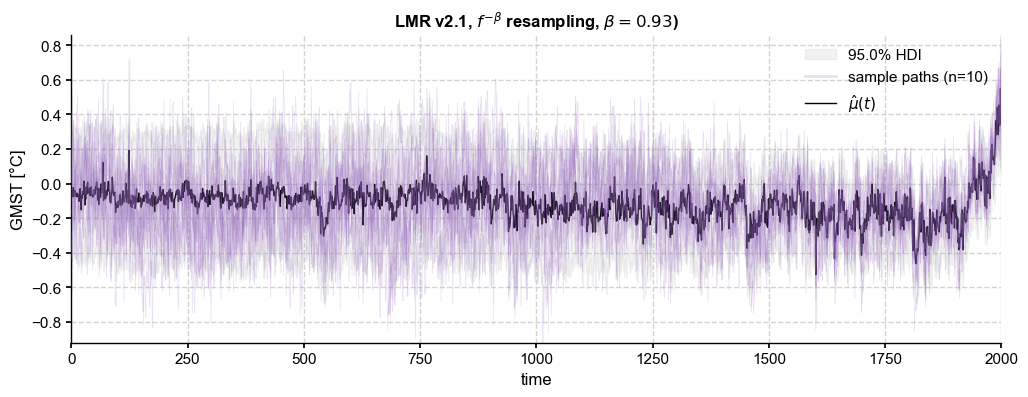

In [52]:
paths_pl = ens_LMR.random_paths(model='power-law',param=beta_o,p=2000)
fig, ax = ens_LMR.plot_hdi(color='silver', median=False, prob=0.95)
paths_pl.plot_traces(ax=ax, alpha=0.2, color='tab:purple', num_traces=10)
ens_LMR.get_mean().plot(ax=ax, color='k', ylabel=None, label=r'$\hat{\mu}(t)$',
                        title= ens_LMR.label + r', $f^{-\beta}$ resampling, ' + fr'$\beta = {beta_o:.2f}$)')
ax.legend()

This indeed looks very similar to the fGn case. In addition, this option enables to simulate longer-memory behavior with exponents steeper than unity. For instance:

100%|████████████████████████████████████████| 5000/5000 [00:11<00:00, 452.70it/s]


<AxesSubplot:title={'center':'LMR v2.1, $f^{-\\beta}$ resampling, $\\beta = 1.20$)'}, xlabel='time', ylabel='GMST [°C]'>

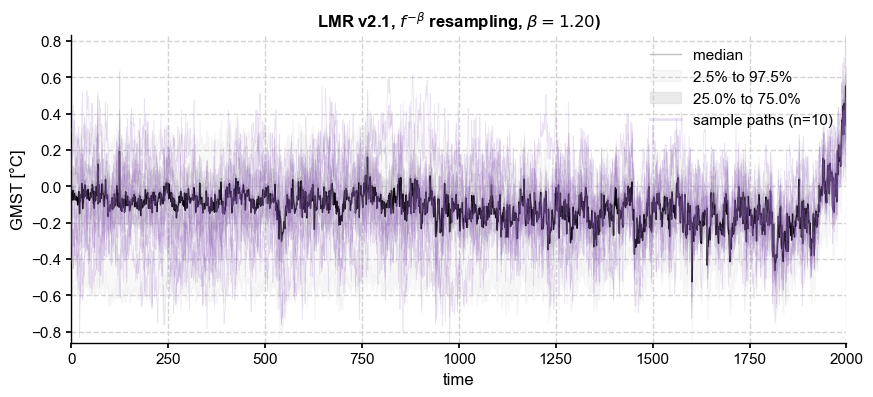

In [23]:
beta = 1.2
paths_pl2 = ens_LMR.random_paths(model='power-law',param=beta,p=2000)
fig, ax = ens_LMR.plot_qs(color='silver')
paths_pl2.plot_traces(ax=ax,alpha=0.2,color='tab:purple', num_traces=10)
ens_LMR.get_mean().plot(ax=ax, color='k', ylabel=None, title= ens_LMR.label + r', $f^{-\beta}$ resampling, ' + fr'$\beta = {beta:.2f}$)')

However, for $\beta > 1$ the process is no longer stationary, which causes issues with modeling its covariance, for instance.

And as before, ensemble spread is preserved:

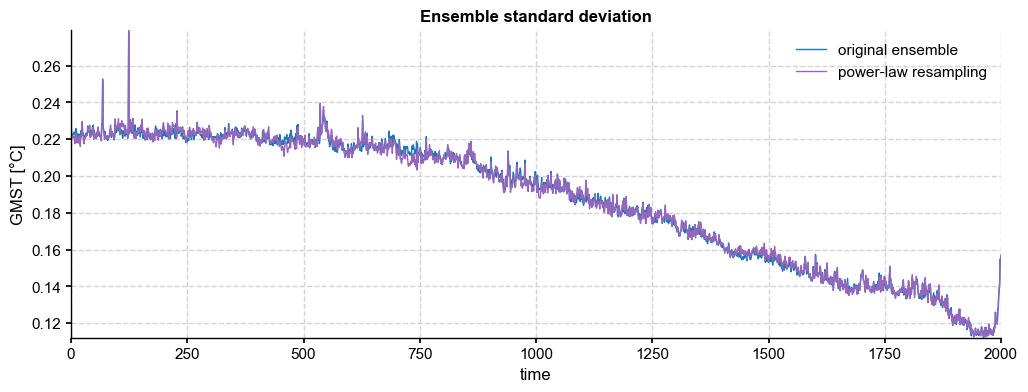

In [24]:
fig, ax = ens_LMR.get_std().plot(label='original ensemble')
paths_pl.get_std().plot(color='tab:purple',ax=ax, label='power-law resampling', title='Ensemble standard deviation')
ax.legend()

In [57]:
pl_ts = paths_pl.to_pyleo()  
PSD_pl = pl_ts.spectral(method='mtm',settings={'standardize':False}) 
PSD_pl_aa = PSD_pl.anti_alias()

Performing spectral analysis on individual series: 100%|██████████| 2000/2000 [03:18<00:00, 10.10it/s]
Applying the anti-alias filter: 100%|██████████| 2000/2000 [00:45<00:00, 44.19it/s]


### fGn resampling
fractional Gaussian noise was popularized by Mandelbrot & Van Ness (1963) and is useful for modeling self-similar, long-memory processes. It has been abundantly used in hydrology, and is increasingly used for modeling GMST as well (see Frederiksen & Rypdal, 2017).  (more background from Frederi would be helpful here)

100%|██████████| 2000/2000 [00:00<00:00, 2393.01it/s]


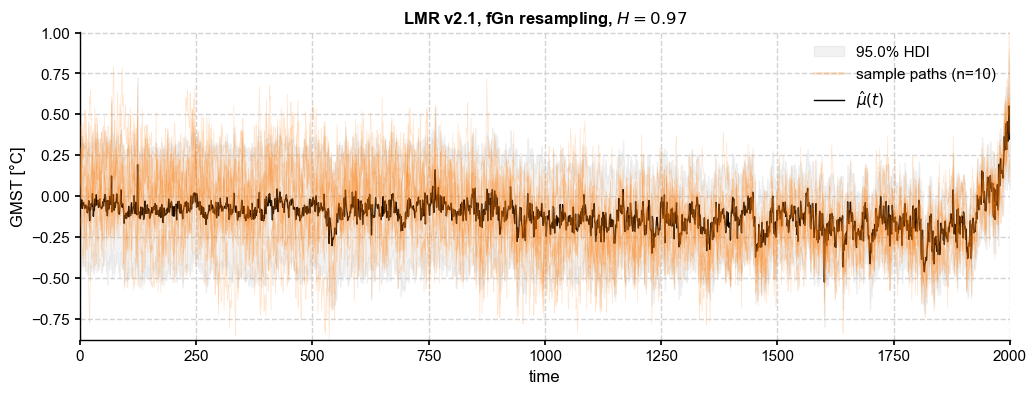

In [54]:
hurst = (beta_o+1)/2
paths_fGn = ens_LMR.random_paths(model='fGn',param=hurst,p=2000)
fig, ax = ens_LMR.plot_hdi(color='silver', median=False, prob=0.95)
paths_fGn.plot_traces(ax=ax,alpha=0.2,color='tab:orange',num_traces =10)
ens_LMR.get_mean().plot(ax=ax, color='k', ylabel=None, label=r'$\hat{\mu}(t)$',
                        title= ens_LMR.label + fr', fGn resampling, $H = {hurst:.2f}$')
ax.legend()

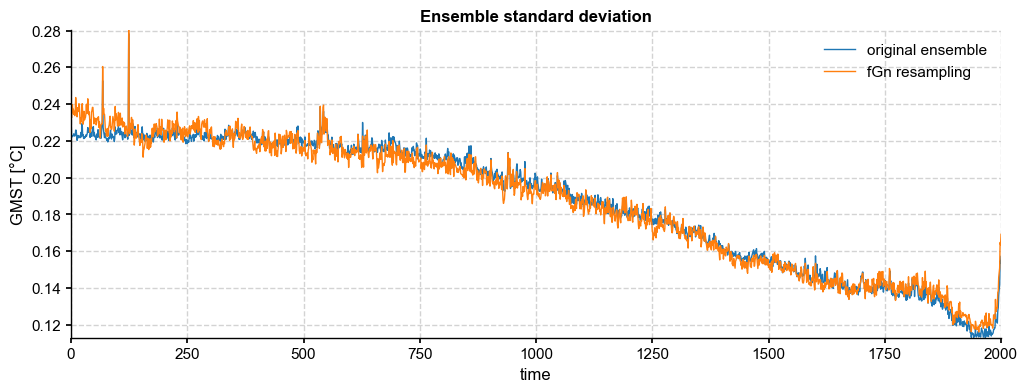

In [55]:
fig, ax = ens_LMR.get_std().plot(label='original ensemble')
paths_fGn.get_std().plot(color='tab:orange',ax=ax, label='fGn resampling', title='Ensemble standard deviation')
ax.legend()

In [56]:
fGn_ts = paths_fGn.to_pyleo()  
PSD_fGn = fGn_ts.spectral(method='mtm',settings={'standardize':False}) 
PSD_fGn_aa = PSD_fGn.anti_alias()

Performing spectral analysis on individual series: 100%|██████████| 2000/2000 [03:05<00:00, 10.77it/s]
Applying the anti-alias filter: 100%|██████████| 2000/2000 [01:11<00:00, 27.98it/s]


Finally, we summarize on a single figure:

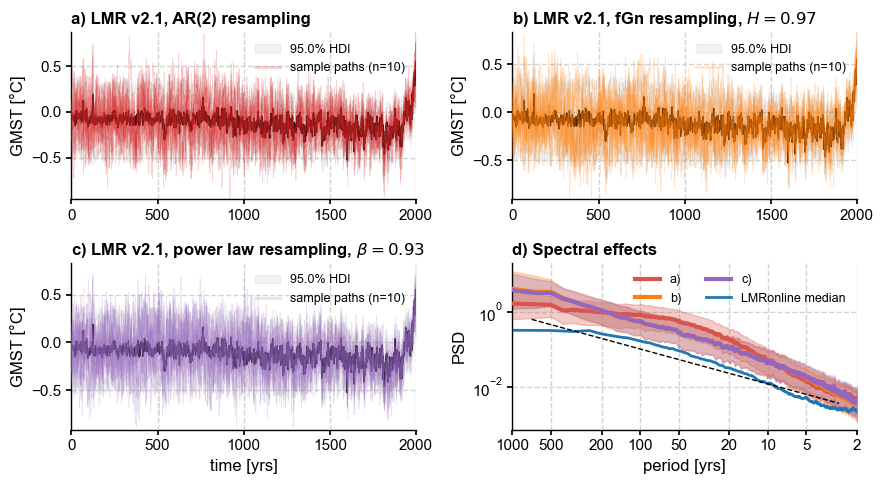

In [64]:
fig, axs = plt.subplots(2,2,figsize=(9,5))
axs = axs.flatten()
# AR resampling
ens_LMR.plot_hdi(color='silver', median=False, prob=0.95, ax= axs[0], title='')
paths_ar.plot_traces(ax=axs[0],alpha=0.2,color='tab:red', 
                     lgd_kwargs={'fontsize':9}, title='')
ens_LMR.get_mean().plot(ax=axs[0], color='k', ylabel=None, label=r'$\hat{\mu}(t)$', title='')
axs[0].set_title('a) ' + ens_LMR.label + ', AR(2) resampling',
                 loc = 'left', fontweight = 'bold')
axs[0].set_xlabel('')
# fGn
ens_LMR.plot_hdi(color='silver', median=False, prob=0.95, ax= axs[1], title='')
paths_fGn.plot_traces(ax=axs[1],alpha=0.2,color='tab:orange',
                      lgd_kwargs={'fontsize':9}, title='')
ens_LMR.get_mean().plot(ax=axs[1], color='k', ylabel=None, 
                        label=r'$\hat{\mu}(t)$', title='')
axs[1].set_xlabel('')
axs[1].set_title('b) ' + ens_LMR.label + fr', fGn resampling, $H = {hurst:.2f}$',
                 loc = 'left', fontweight = 'bold')                
# power law
ens_LMR.plot_hdi(color='silver', median=False, prob=0.95, ax= axs[2], title='')
paths_pl.plot_traces(ax=axs[2],alpha=0.2,color='tab:purple', title='',
                     lgd_kwargs={'fontsize':9})
ens_LMR.get_mean().plot(ax=axs[2], color='k', ylabel=None, label=r'$\hat{\mu}(t)$', title='')
                        
axs[2].set_title('c) ' + ens_LMR.label + fr', power law resampling, $\beta = {beta_o:.2f}$',
                 loc = 'left', fontweight = 'bold') 
axs[2].set_xlabel('time [yrs]')
# spectra
PSD_ar_aa.plot_envelope(ax=axs[3], members_plot_num=0)
axs[3].set_title('d) Spectral effects',
                 loc = 'left', fontweight = 'bold')
PSD_fGn_aa.plot_envelope(ax=axs[3], members_plot_num=0, 
                         curve_clr='tab:orange', shade_clr='tab:orange')
PSD_pl_aa.plot_envelope(ax=axs[3], members_plot_num=0, 
                        curve_clr='tab:purple', shade_clr='tab:purple')
# plot median
#esm_rnd = ens_o2000.get_median()
#esm_rnd = esm_rnd.to_pyleo()
#esm_rnd_spec = esm_rnd.spectral(method ='mtm',settings={'standardize':False})
#esm_rnd_beta = esm_rnd_spec.anti_alias().beta_est() # estimate spectral exponent
#esm_rnd_beta.plot(ax=axs[3], ylabel='PSD', xlabel = 'period [yrs]')
PSD_oaa_beta.plot(ax=axs[3], ylabel='PSD', xlabel = 'period [yrs]', 
                  colors = 'tab:blue', plot_kwargs={'linewidth':2})
h, l = axs[3].get_legend_handles_labels()
hdls = []; lbls =[]
hdls.append(h[0]); lbls.append('a)')
hdls.append(h[2]); lbls.append('b)')
hdls.append(h[4]); lbls.append('c)')
hdls.append(h[6]); lbls.append('LMRonline median')

axs[3].legend(handles=hdls, labels= lbls, loc='upper right', ncol=2, fontsize=9)

fig.tight_layout()

In [65]:
fig.savefig('../figures/Fig5_resampling.pdf',dpi=250,bbox_inches='tight')

## Conclusion

`pens` now has 4 options for resampling the posterior ensemble of offline DA methods: 1 non-parametric method and 3 parametric ones -- all distribution-preserving. The choice of model is subjective, and the choice of parameter requires somewhat careful thinking, so we refrain from providing one-size-fits-all defaults that would encourage users to rely on general recipes that may not apply to the case at hand.  